Question 1: Where do people stay? Which neighborhoods are the most popular ones?

Read in the necessary libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To achive an uniform appearance of all plots the 'darkgrid' template of seaborn is set as main visualization style
sns.set(style="darkgrid")

Read in the data to be analyzed

In [20]:
df_detailed_listings = pd.read_csv('./resource/detailed_listings.csv')

Part 1. Get an overview of the data and specify the parts which are of interest.

In [21]:
df_detailed_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

The raw data containes a lot of information we do not want to process or use for predicting any features, so we drop them. For our purpose features which contain for example urls or similar should be droped befor starting to analyze the data.

In [22]:
df_listing_cleaned = df_detailed_listings.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url', \
    'host_thumbnail_url', 'host_picture_url', 'latitude', 'longitude', 'calendar_updated', 'calendar_last_scraped', 'license'], 
    axis=1).copy()

Furthermore there are also columns which contain no or way to few values to be valuable to our predictions and analysis. So they are droped as well.

In [23]:
# Searching for columns missing all data:
print(df_listing_cleaned.loc[:, df_listing_cleaned.isnull().all()].columns)

# drop columns which have no values
print(len(df_listing_cleaned.columns))
df_listing_cleaned = df_listing_cleaned.dropna(axis=1, how='all')
print(len(df_listing_cleaned.columns))

Index(['bathrooms'], dtype='object')
62
61


We are interested in comparing different neighborhoods to each other regarding different questions of interest. Therefore we take a look which neighborhoods are included in the dataset.

In [24]:
df_listing_cleaned.neighbourhood_group_cleansed.unique()

array(['Pankow', 'Friedrichshain-Kreuzberg', 'Mitte',
       'Treptow - Köpenick', 'Neukölln', 'Tempelhof - Schöneberg',
       'Charlottenburg-Wilm.', 'Marzahn - Hellersdorf',
       'Steglitz - Zehlendorf', 'Spandau', 'Reinickendorf', 'Lichtenberg'],
      dtype=object)

To work with the data we need to clean, wrangle and modify some data first. The price data for example isn't suitable as it is to be analyzed and visualized because its in a string format and includes also the $ sign.

In [25]:
df_listing_cleaned.price.head()

0     $83.00
1    $180.00
2    $280.00
3     $70.00
4    $135.00
Name: price, dtype: object

In the next step we reformat the column and change the datatype to be a integer datatype.

In [26]:
df_listing_cleaned['price'] = df_listing_cleaned.price.str[1:].str.replace(',','').str.split('.').str[0].astype(int)

In [27]:
df_listing_cleaned.price.head()

0     83
1    180
2    280
3     70
4    135
Name: price, dtype: int64

We analyze the availability of all listings in Berlin over several time frames and invert them to get the current number of days booked. We can not filter if the hosts did reserve their apartment for their own or blocked the availability for other reasons, but it should give a hint which neighborhoods are the most frequently booked ones.

Gather all data of interest out of the main dataframe of all listings, filtered for listings that are marked as 'availale' through the column 'has_availality'.

In [28]:
df_analyze_q1 = df_listing_cleaned.loc[df_listing_cleaned['has_availability'] == 't',['neighbourhood_group_cleansed', 'price', 'availability_30', 'availability_60', 'availability_90', 'availability_365']].copy()

Filter some outliers:
- zero availality over the whole year
- listings where the availabilities for all three timeframes are the same (filter hosts who only open up booking for certain periods of time)

In [29]:
# filter for not listed apartments
df_analyze_q1 = df_analyze_q1[df_analyze_q1.availability_365 != 0].copy()

In [30]:
# filter for listings bookable only for certain periods of time
print(f'Listings only bookable for certain timeframes: {df_analyze_q1.query("availability_30 == availability_60 == availability_90 == availability_365").shape[0]}')
index = df_analyze_q1.query("availability_30 == availability_60 == availability_90 == availability_365").index
df_analyze_q1 = df_analyze_q1.drop(index=index, axis=0).copy()

Listings only bookable for certain timeframes: 572


For the days a listing is already booked we need to invert the availability over the given timeframesz

In [31]:
df_analyze_q1['booked_30'] = 30 - df_analyze_q1.availability_30
df_analyze_q1['booked_60'] = 60 - df_analyze_q1.availability_60
df_analyze_q1['booked_90'] = 90 - df_analyze_q1.availability_90
df_analyze_q1['booked_365'] = 365 - df_analyze_q1.availability_365

To visualize the data we reshape the dataframe in the way that we melt all columns regarding different booking timeframes into one column. 

In [32]:
df_plot_q1 = df_analyze_q1.melt(
    value_vars=['booked_30','booked_60','booked_90'], 
    id_vars=['neighbourhood_group_cleansed','price'],
    var_name='booking_tf',
    value_name='days_booked'
    ).copy()

And plot them as a grouped barplot:

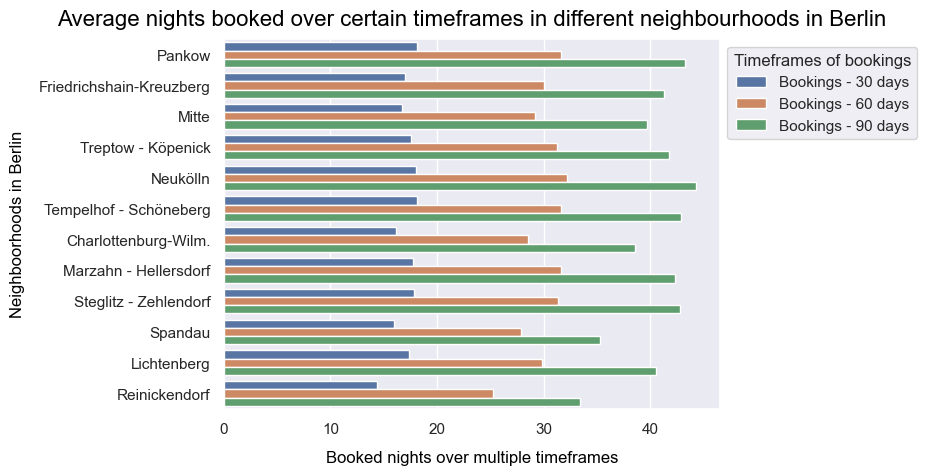

In [33]:
fig = sns.barplot(
    data=df_plot_q1, 
    y='neighbourhood_group_cleansed', 
    x='days_booked', 
    hue='booking_tf', 
    ci=None,
    )
fig.set_title('Average nights booked over certain timeframes in different neighbourhoods in Berlin', pad=10, fontsize=16, color='black'); 
fig.set_xlabel('Booked nights over multiple timeframes', fontsize=12, color='black', labelpad=10);
fig.set_ylabel('Neighboorhoods in Berlin', fontsize=12, color='black', labelpad=10);

fig.legend(loc=1, title='Timeframes of bookings', labels=['Bookings - 30 days','Bookings - 60 days','Bookings - 90 days'])
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

The plot shows that the number of booked nights regarding different timeframes doesn't differ that much between all neighborhoods, at least regarding the 30 and 60 day timeframe. Comparing the number of booked nights over the next year though, the differences seem to be of more significance. Therefore we use this timeframe for our visualization:

In [34]:
# order = df_analyze_q2.groupby('neighbourhood_group_cleansed')['booked_365'].mean().sort_values(ascending=False).index.to_list()

In [35]:
df_analyze_q1_agg = df_analyze_q1.groupby('neighbourhood_group_cleansed', as_index=False).aggregate(nights_booked=('booked_365', 'mean'))

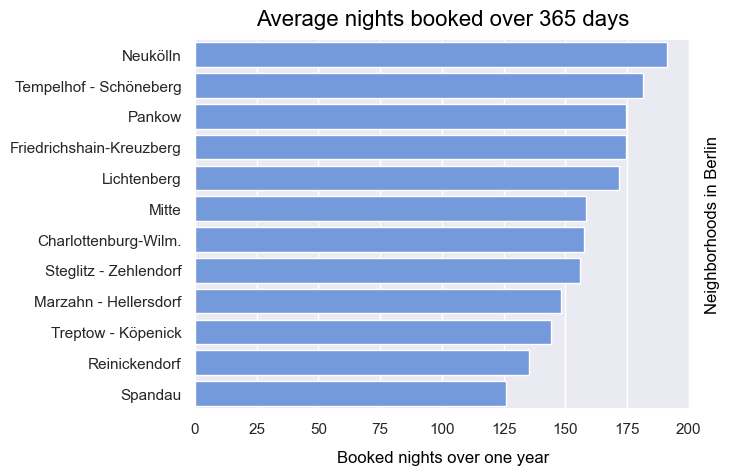

In [36]:
fig = sns.barplot(data=df_analyze_q1_agg.sort_values(by='nights_booked', ascending=False), x='nights_booked', y='neighbourhood_group_cleansed', ci=None, color='cornflowerblue')

fig.set_title('Average nights booked over 365 days', pad=10, fontsize=16, color='black'); 
fig.set_xlabel('Booked nights over one year', fontsize=12, color='black', labelpad=10);
fig.set_ylabel('Neighborhoods in Berlin', fontsize=12, color='black', labelpad=10);
fig.yaxis.set_label_position('right');